In [ ]:
import zipfile

# Extracting ZIP file for the images and CSV file
with zipfile.ZipFile('/content/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Imports

In [ ]:
# Importing libraries

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras import datasets, layers, models
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

# Importing Data 

In [ ]:
# reading the data from data_labels_mainData csv files 

data_main = pd.read_csv('/content/data_labels_mainData.csv')
data_main = data_main[['InstanceID','patientID','ImageName', 'isCancerous']]


# reading the data from data_labels_extraData csv files 
data_extra = pd.read_csv('/content/data_labels_extraData.csv')
data_extra = data_extra[['InstanceID','patientID','ImageName', 'isCancerous']]

# concatinating the data 
data = pd.concat([data_main, data_extra], axis=0)



# Data Exploration

In [ ]:
# visulizing data set 
data.head()

,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   20280 non-null  int64 
 1   patientID    20280 non-null  int64 
 2   ImageName    20280 non-null  object
 3   isCancerous  20280 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 792.2+ KB


In [ ]:
# cheacming how class is distributed
data['isCancerous'].value_counts()

0    13211
1     7069
Name: isCancerous, dtype: int64

In [ ]:
# check for duplicate data 
data[data.duplicated('InstanceID', keep=False)]


,InstanceID,patientID,ImageName,isCancerous


In [ ]:
# check for duplicate data 
data[data.duplicated('ImageName', keep=False)]

,InstanceID,patientID,ImageName,isCancerous


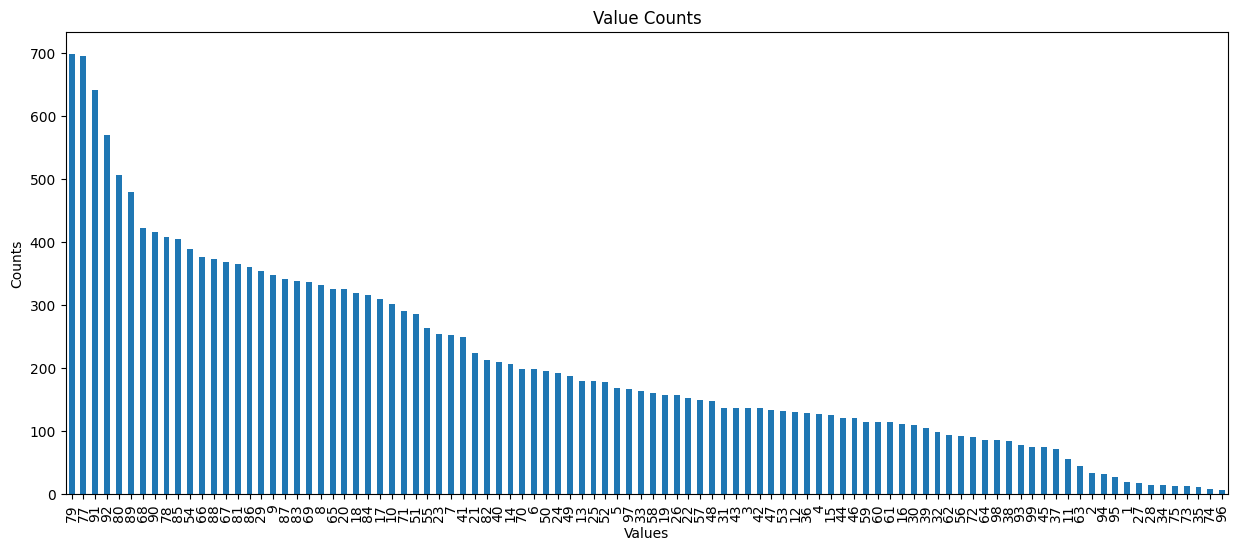

In [ ]:
# check for how data distributed along patient id's

value_counts=data['patientID'].value_counts()

plt.figure(figsize=(15, 6))  # Set the figure size (optional)
value_counts.plot.bar()
plt.xlabel('Values')
plt.ylabel('Counts')
plt.title('Value Counts')
plt.show()

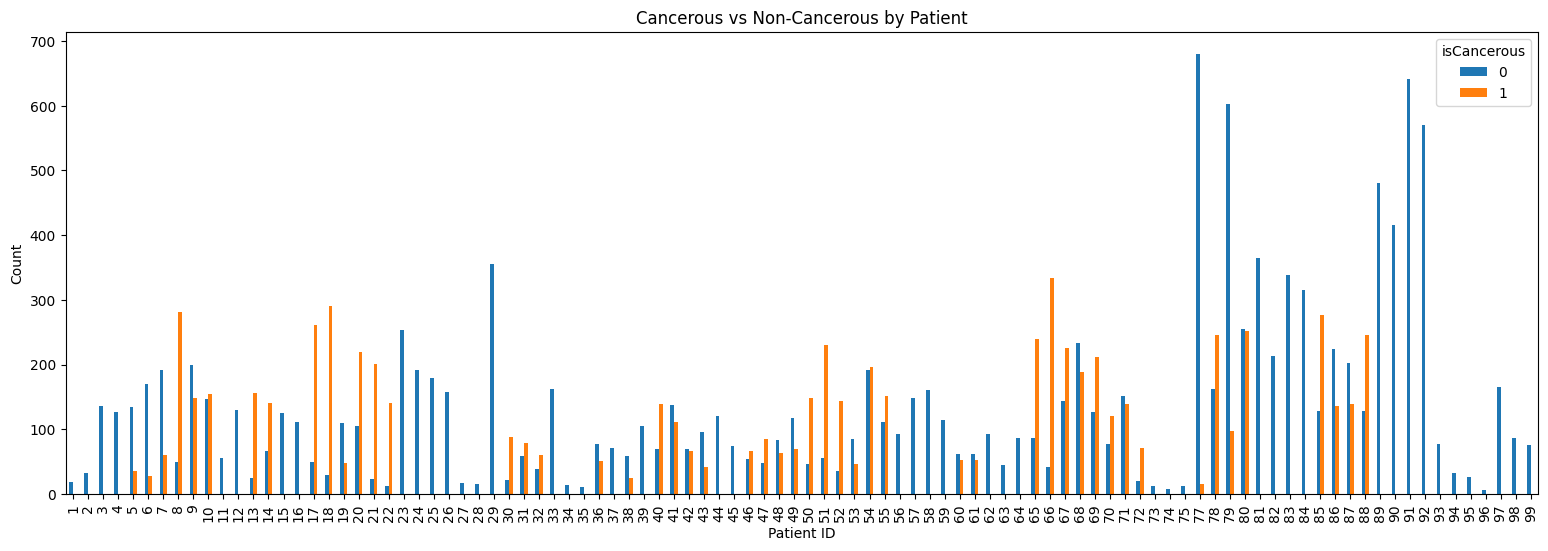

In [ ]:
# checking how each class is distributed along patients id

grouped_data = data.groupby(['patientID', 'isCancerous']).size().unstack()

# Create a figure and axes with the desired size
fig, ax = plt.subplots(figsize=(19, 6))

# Plotting the bar graph
grouped_data.plot(kind='bar', ax=ax)
plt.xlabel('Patient ID')
plt.ylabel('Count')
plt.title('Cancerous vs Non-Cancerous by Patient')
plt.legend(title='isCancerous')
plt.show()

# Dividing the data into test and train 

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42,stratify= data['isCancerous'])

In [ ]:
# checking how target class is divided among test data 
test_data['isCancerous'].value_counts()

0    1321
1     707
Name: isCancerous, dtype: int64

# Performing data augmentation on train data to balance the binary classes

In [ ]:
train_data.head()

,InstanceID,patientID,ImageName,isCancerous
580,4186,6,4186.png,0
7163,18961,45,18961.png,0
169,18935,3,18935.png,0
8398,3854,52,3854.png,1
4807,2665,80,2665.png,0


In [ ]:
# droping Instance ID and Patient ID as they dont tend to provide much information for classification
train_data = train_data.drop(columns=['InstanceID', 'patientID'])
train_df = train_data.reset_index(drop=True)
train_df = train_data

In [ ]:
numbers = [1699, 2289, 3671, 1247]
multiplier = 1.0

for number in numbers:
    # Generate a random factor between 0.9 and 1.1
    factor = 0.9 + (0.2 * np.random.random())
    # Multiply the number by the factor
    new_number = int(number * factor)
    print(new_number)

1784
2412
3811
1130


## Data Augmentation Here we are creating duplicate images of class which is having less number of images in this case its cancerous images 

In [ ]:
# we could see that non-cancerous images are double the size of cancerous images we are duplicating each image with the help of data augmentation 
# where either data is rotated or zoomed or width shifted or height shifted randomly and we are concating the images data into df and concating it test_df

import os
import pandas as pd
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

# Define the base path to the folder containing the images
image_base_folder = "/content/patch_images"

# Define the paths to the augmented dataset
augmented_dir = "/content/augmented_dataset"
augmented_image_dir = os.path.join(augmented_dir)

# Create the augmented dataset directories if they don't exist
os.makedirs(augmented_image_dir, exist_ok=True)

# Data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
def augment_data(image_paths, output_dir):
    augmented_image_paths = []
    for image_path in image_paths:
        img = Image.open(image_path)
        img = img.resize((27, 27))  # Adjust the size to your desired input size

        # Perform data augmentation
        img_arr = np.array(img)
        img_arr = np.expand_dims(img_arr, axis=0)  # Add batch dimension for data generator
        
        augmented_image_name = f"augmented_{os.path.splitext(os.path.basename(image_path))[0]}.png"
        augmented_image_path = os.path.join(output_dir, augmented_image_name)
        
        datagen.fit(img_arr)
        for i, batch in enumerate(datagen.flow(img_arr, batch_size=1, save_to_dir=output_dir, save_prefix='', save_format='png')):
            augmented_image_temp_path = os.path.join(output_dir, f"temp_augmented_{i}.png")
            Image.fromarray(batch[0].astype(np.uint8)).save(augmented_image_temp_path)
            os.rename(augmented_image_temp_path, augmented_image_path)
            augmented_image_paths.append(augmented_image_path)
            break  # Generate only one augmented image per original image

    return augmented_image_paths

# Split the DataFrame based on the class label (cancerous or non-cancerous)
cancerous_df = train_df[train_df['isCancerous'] == 1]
non_cancerous_df = train_df[train_df['isCancerous'] == 0]

# Determine the number of samples in each class
cancerous_samples = len(cancerous_df)
non_cancerous_samples = len(non_cancerous_df)

# Determine the class with fewer samples and its corresponding DataFrame
if cancerous_samples < non_cancerous_samples:
    minority_class_samples = cancerous_samples
    minority_class_df = cancerous_df
    majority_class_df = non_cancerous_df
else:
    minority_class_samples = non_cancerous_samples
    minority_class_df = non_cancerous_df
    majority_class_df = cancerous_df

# Get the image paths for the minority class
minority_image_paths = [os.path.join(image_base_folder, image_name) for image_name in minority_class_df['ImageName']]

# Perform data augmentation for the minority class
augmented_image_paths = augment_data(minority_image_paths, augmented_image_dir)

# Generate the class labels for the augmented images
augmented_class_labels = [minority_class_df['isCancerous'].iloc[0]] * len(augmented_image_paths)

# Create a DataFrame for the augmented images
augmented_df = pd.DataFrame({'ImageName': [os.path.basename(image_path) for image_path in augmented_image_paths],
                             'isCancerous': augmented_class_labels})

# Concatenate the augmented DataFrame with the original majority class DataFrame
balanced_df = pd.concat([majority_class_df, augmented_df], ignore_index=True)

# Update the original DataFrame with the augmented image names and class labels
train_df = pd.concat([train_df, augmented_df], ignore_index=True)


In [ ]:
# all the augmented images are stored in different floder so moving those folders into one folder 

import shutil

def move_augmented_files(source_dir, destination_dir):
    os.makedirs(destination_dir, exist_ok=True)

    for file_name in os.listdir(source_dir):
        if file_name.startswith("augmented"):
            source_path = os.path.join(source_dir, file_name)
            destination_path = os.path.join(destination_dir, file_name)
            shutil.move(source_path, destination_path)

# Specify the source and destination directories
source_dir = "/content/augmented_dataset"
destination_dir = "/content/patch_images"

# Move the augmented files from the source directory to the destination directory
move_augmented_files(source_dir, destination_dir)


In [ ]:
# after data augmentation we could increase the cancerous images to double so now the data distribution is almost equal

train_df['isCancerous'].value_counts()

1    12724
0    11890
Name: isCancerous, dtype: int64

# Spliting the Train data into train data and validation data 

 * 80 % for train data
 * 20 % for Validation 


In [ ]:
train_df['isCancerous'] = train_df['isCancerous'].astype(str)

In [ ]:
#Splitting data into train, test and validation
train_data, val_data = train_test_split(train_df, test_size=0.20, random_state=42, stratify= train_df['isCancerous'])
print("Train data : {}, Val Data: {}".format(train_data.shape[0], val_data.shape[0]))

Train data : 19691, Val Data: 4923


In [ ]:
# Real time data augmentation


train_datagen=ImageDataGenerator(zoom_range=0.1,shear_range=0.2,rescale=1/255,horizontal_flip=True)
# train_datagen=ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)


 
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

valid_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')


test_data['isCancerous'] = test_data['isCancerous'].astype(str)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images',
        
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27,27),
        batch_size=batch_size,
        class_mode='binary')

Found 19691 validated image filenames belonging to 2 classes.
Found 4923 validated image filenames belonging to 2 classes.
Found 2028 validated image filenames belonging to 2 classes.


# Evaluation Function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def evaluate_model(model, model_name, test_generator, valid_generator, train_generator):
    # Get predictions for test, validation, and train data
    test_labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])
    test_predictions = model.predict(test_generator) 

    validation_labels = np.concatenate([valid_generator[i][1] for i in range(len(valid_generator))])
    val_predictions = model.predict(valid_generator) 

    train_labels = np.concatenate([train_generator[i][1] for i in range(len(train_generator))])
    train_predictions = model.predict(train_generator)

    # Confusion Matrix
    test_cm = confusion_matrix(test_labels, test_predictions > 0.5)
    val_cm = confusion_matrix(validation_labels, val_predictions > 0.5)
    train_cm = confusion_matrix(train_labels, train_predictions > 0.5)

    # ROC Curve
    test_fpr, test_tpr, _ = roc_curve(test_labels, test_predictions)
    val_fpr, val_tpr, _ = roc_curve(validation_labels, val_predictions)
    train_fpr, train_tpr, _ = roc_curve(train_labels, train_predictions)

    test_auc = auc(test_fpr, test_tpr)
    val_auc = auc(val_fpr, val_tpr)
    train_auc = auc(train_fpr, train_tpr)

    # Calculate performance metrics for test data
    accuracy_test = (test_cm[0, 0] + test_cm[1, 1]) / sum(sum(test_cm))
    precision_test = test_cm[1, 1] / (test_cm[1, 1] + test_cm[0, 1])
    recall_test = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])
    specificity_test = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])
    f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)

    # Calculate performance metrics for validation data
    accuracy_val = (val_cm[0, 0] + val_cm[1, 1]) / sum(sum(val_cm))
    precision_val = val_cm[1, 1] / (val_cm[1, 1] + val_cm[0, 1])
    recall_val = val_cm[1, 1] / (val_cm[1, 1] + val_cm[1, 0])
    specificity_val = val_cm[0, 0] / (val_cm[0, 0] + val_cm[0, 1])
    f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)

    # Calculate performance metrics for train data
    accuracy_train = (train_cm[0, 0] + train_cm[1, 1]) / sum(sum(train_cm))
    precision_train = train_cm[1, 1] / (train_cm[1, 1] + train_cm[0, 1])
    recall_train = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0])
    specificity_train = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])
    f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

    # Set the column width for alignment
    column_width = 20

    # Print performance metrics for test data
    print(f'{model_name}-Test,Validation and Train Metrics'.center(column_width*3))
    print(f" Test Model: {model_name:<{column_width}}\tValidation: {model_name:<{column_width}}\t\tTrain: {model_name}")
    print(f" Test Accuracy: {accuracy_test:<{column_width}.4f}\tValidation Accuracy: {accuracy_val:<{column_width}.4f}\tTrain Accuracy: {accuracy_train:.4f}")
    print(f" Test Precision: {precision_test:<{column_width}.4f}\tValidation Precision: {precision_val:<{column_width}.4f}\tTrain Precision: {precision_train:.4f}")
    print(f" Test Recall: {recall_test:<{column_width}.4f}\tValidation Recall: {recall_val:<{column_width}.4f}\t\tTrain Recall: {recall_train:.4f}")
    print(f" Test Specificity: {specificity_test:<{column_width}.4f}\tValidation Specificity: {specificity_val:<{column_width}.4f}\tTrain Specificity: {specificity_train:.4f}")
    print(f" Test F1 Score: {f1_score_test:<{column_width}.4f}\tValidation F1 Score: {f1_score_val:<{column_width}.4f}\tTrain F1 Score: {f1_score_train:.4f}")


    # Plotting
    # Confusion Matrix
    plt.figure(figsize=(20, 2))
    plt.subplot(1, 4, 1)
    plt.title(f'{model_name} - Test Confusion Matrix', fontsize=8)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 4, 2)
    plt.title(f'{model_name} - Validation Confusion Matrix', fontsize=8)
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 4, 3)
    plt.title(f'{model_name} - Train Confusion Matrix', fontsize=8)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # ROC Curve
    plt.subplot(1, 4, 4)
    plt.plot(test_fpr, test_tpr, label=f'Test ROC Curve (AUC = {test_auc:.2f})')
    plt.plot(val_fpr, val_tpr, label=f'Validation ROC Curve (AUC = {val_auc:.2f})')
    plt.plot(train_fpr, train_tpr, label=f'Train ROC Curve (AUC = {train_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve', fontsize=10)
    plt.legend()
    plt.show()







#Base model Creation (Not included in Report)

In [ ]:
#Creating new model and adding layers
baseModel= models.Sequential()
baseModel.add(Flatten(input_shape=(27,27,3)))
baseModel.add(Dense(256))
baseModel.add(Dense(1,activation='sigmoid'))

baseModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseModel.compile(optimizer='SGD',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

baseModelHistory = baseModel.fit(train_generator,
                                 validation_data=valid_generator,
                                 epochs=8)


Epoch 1/8
616/616 [==============================] - 25s 32ms/step - loss: 0.6082 - accuracy: 0.7279 - val_loss: 0.4278 - val_accuracy: 0.7987
Epoch 2/8
616/616 [==============================] - 19s 30ms/step - loss: 0.4206 - accuracy: 0.8102 - val_loss: 0.3802 - val_accuracy: 0.8381
Epoch 3/8
616/616 [==============================] - 20s 33ms/step - loss: 0.4010 - accuracy: 0.8234 - val_loss: 0.3816 - val_accuracy: 0.8316
Epoch 4/8
616/616 [==============================] - 18s 30ms/step - loss: 0.3933 - accuracy: 0.8243 - val_loss: 0.4343 - val_accuracy: 0.8042
Epoch 5/8
616/616 [==============================] - 18s 30ms/step - loss: 0.3874 - accuracy: 0.8295 - val_loss: 0.3789 - val_accuracy: 0.8361
Epoch 6/8
616/616 [==============================] - 20s 33ms/step - loss: 0.3854 - accuracy: 0.8279 - val_loss: 0.3757 - val_accuracy: 0.8347
Epoch 7/8
616/616 [==============================] - 18s 30ms/step - loss: 0.3837 - accuracy: 0.8283 - val_loss: 0.4453 - val_accuracy: 0.7965

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(6,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()



616/616 [==============================] - 16s 26ms/step
       base Model -Test,Validation and Train Metrics        
 Test Model: base Model          	Validation: base Model          		Train: base Model 
 Test Accuracy: 0.7806              	Validation Accuracy: 0.8253              	Train Accuracy: 0.8319
 Test Precision: 0.6287              	Validation Precision: 0.7892              	Train Precision: 0.7925
 Test Recall: 0.9052              	Validation Recall: 0.9033              		Train Recall: 0.9142
 Test Specificity: 0.7139              	Validation Specificity: 0.7418              	Train Specificity: 0.7438
 Test F1 Score: 0.7420              	Validation F1 Score: 0.8424              	Train F1 Score: 0.8490


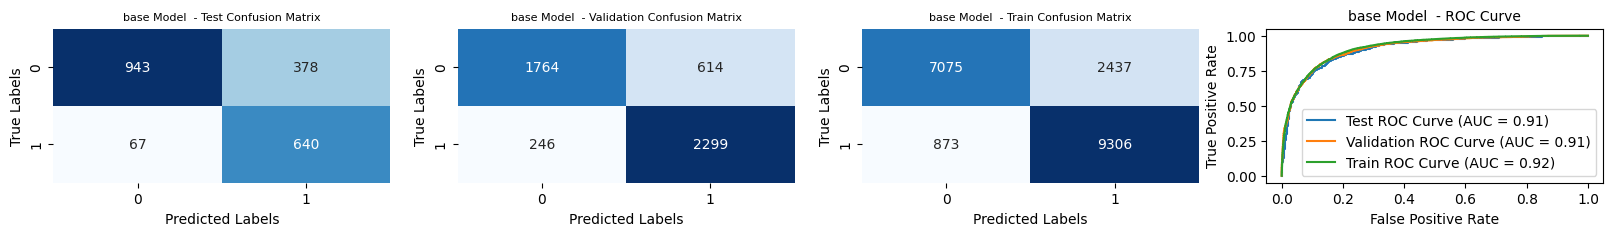

In [ ]:
evaluate_model(baseModel, "base Model ", test_generator, valid_generator,train_generator)

#Building Custom model

In [ ]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential

activationMidLayers = 'relu'
secondModel = models.Sequential()
secondModel.add(Conv2D(16, (3,3),activation = activationMidLayers, padding='same', input_shape = (27,27,3)))
secondModel.add(MaxPool2D(pool_size=(2,2)))
secondModel.add(Conv2D(32, (3,3), padding='same',activation = activationMidLayers))
secondModel.add(MaxPool2D(pool_size=(2,2)))
secondModel.add(Conv2D(64, (3,3), padding='same',activation = activationMidLayers))
secondModel.add(MaxPool2D(pool_size=(2,2)))
secondModel.add(Dropout(rate=0.25))
secondModel.add(Flatten())
secondModel.add(Dense(units=64,activation = activationMidLayers))
secondModel.add(Dropout(rate=0.25))
secondModel.add(Dense(units=1,activation = 'sigmoid'))


secondModel.summary()

from sklearn import metrics
secondModel.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)        

In [ ]:
from sklearn import metrics
secondModel.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#earlyStopping
earlyStopping = EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,mode='auto')

#modelCheckpoint
modelAccuracy = ModelCheckpoint(monitor='val_accuracy',filepath="./bestAccuracteModel.h5",verbose=1,save_best_only= True, mode='auto')
call =[earlyStopping,modelAccuracy]

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


seconsModelHistory = secondModel.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks=call)

Epoch 1/50


<ipython-input-41-38b18b11f38e>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  seconsModelHistory = secondModel.fit_generator(generator=train_generator,


615/615 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.7848
Epoch 1: val_accuracy improved from -inf to 0.85682, saving model to ./bestAccuracteModel.h5
615/615 [==============================] - 27s 33ms/step - loss: 0.4447 - accuracy: 0.7848 - val_loss: 0.3448 - val_accuracy: 0.8568
Epoch 2/50
615/615 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8483
Epoch 2: val_accuracy did not improve from 0.85682
615/615 [==============================] - 20s 33ms/step - loss: 0.3523 - accuracy: 0.8483 - val_loss: 0.3444 - val_accuracy: 0.8542
Epoch 3/50
615/615 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8609
Epoch 3: val_accuracy improved from 0.85682 to 0.87520, saving model to ./bestAccuracteModel.h5
615/615 [==============================] - 21s 34ms/step - loss: 0.3270 - accuracy: 0.8609 - val_loss: 0.2954 - val_accuracy: 0.8752
Epoch 4/50
614/615 [============================>.] - ETA: 0s - loss: 0.3056 - accur

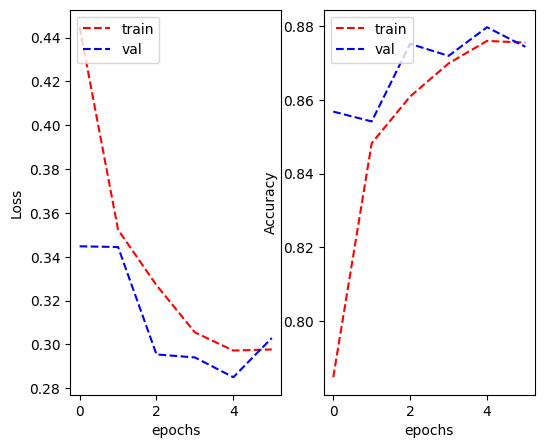

In [ ]:
# model accuracy
plot_learning_curve(seconsModelHistory.history['loss'], seconsModelHistory.history['val_loss'], 
                    seconsModelHistory.history['accuracy'], seconsModelHistory.history['val_accuracy'], 
                    metric_name='Accuracy')
from keras.models import load_model

best_model_path = "/content/bestAccuracteModel.h5"
secondModel = load_model(best_model_path)


616/616 [==============================] - 18s 29ms/step
      Second Model -Test,Validation and Train Metrics       
 Test Model: Second Model        	Validation: Second Model        		Train: Second Model 
 Test Accuracy: 0.8831              	Validation Accuracy: 0.8793              	Train Accuracy: 0.8819
 Test Precision: 0.8246              	Validation Precision: 0.9114              	Train Precision: 0.8854
 Test Recall: 0.8444              	Validation Recall: 0.8491              		Train Recall: 0.8863
 Test Specificity: 0.9039              	Validation Specificity: 0.9117              	Train Specificity: 0.8772
 Test F1 Score: 0.8344              	Validation F1 Score: 0.8792              	Train F1 Score: 0.8859


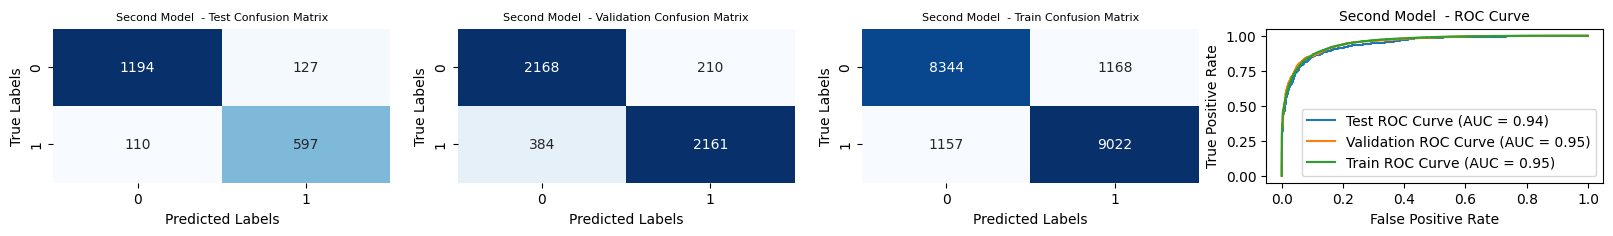

In [ ]:
evaluate_model(secondModel, "Second Model ", test_generator, valid_generator,train_generator)

In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.0 MB/s eta 0:00:00


# Keras Tunner - Hyperparameter Tuning

In [ ]:
import keras_tuner



# Define the model-building function
def build_model(hp):
    model = keras.Sequential()
    
    # Tune the number of layers
    
    num_layers = hp.Int('num_layers', min_value=1, max_value=4, step=1)
    
    # Add convolutional layers
    model.add(keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
        kernel_size=(3,3),padding='same',
        activation='relu',
        input_shape=(27,27,3)
    ))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    for i in range(num_layers-1):
        model.add(keras.layers.Conv2D(filters=hp.Int('conv_{}_filter'.format(i+2), min_value=16, max_value=128, step=16),
        kernel_size=(3,3),padding='same',
        activation='relu' ))
                # Add conditional check for pooling
        if model.output_shape[1] >= 2 and model.output_shape[2] >= 2:
            model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Flatten())
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=4, step=1)
    
    # Add dense layers
    for i in range(num_dense_layers):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=2, max_value=64, step=8),
                                     activation='relu'))
        model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model



In [ ]:
# Instantiate the tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='op124534',
    project_name='cancer_detection'
)

# early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.01,verbose=1, patience=3)
earlyStopping_1 = EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,mode='auto')
# Perform the hyperparameter search
tuner.search(train_generator,
             epochs=50,
             validation_data=valid_generator,
             callbacks=[earlyStopping_1])

# Retrieve the best model
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Trial 10 Complete [00h 01m 26s]
val_accuracy: 0.5169612169265747

Best val_accuracy So Far: 0.8563883900642395
Total elapsed time: 00h 25m 01s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 80)        2240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 80)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 80)        57680     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 80)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 16)

616/616 [==============================] - 18s 29ms/step
    Keras Tuner model-Test,Validation and Train Metrics     
 Test Model: Keras Tuner model   	Validation: Keras Tuner model   		Train: Keras Tuner model
 Test Accuracy: 0.8462              	Validation Accuracy: 0.8564              	Train Accuracy: 0.8583
 Test Precision: 0.7365              	Validation Precision: 0.8576              	Train Precision: 0.8443
 Test Recall: 0.8699              	Validation Recall: 0.8660              		Train Recall: 0.8900
 Test Specificity: 0.8335              	Validation Specificity: 0.8461              	Train Specificity: 0.8244
 Test F1 Score: 0.7977              	Validation F1 Score: 0.8618              	Train F1 Score: 0.8666


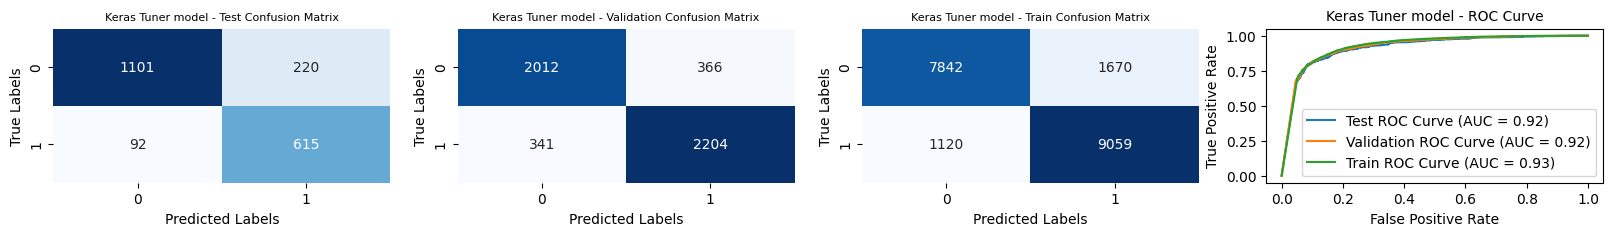

In [ ]:
evaluate_model(best_model, "Keras Tuner model", test_generator, valid_generator,train_generator)

# Vgg 16 model (Not included in Report)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

batch_size=32

# Define data generators for training, validation, and testing sets
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/content/patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary')

valid_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='/content/patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/content/patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary')

# Create an instance of the VGG16 model with imagenet weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze all the layers in the VGG16 model except the last few
for layer in vgg16.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of the VGG16 model with L2 regularization and dropout
x = vgg16.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create a new model with the VGG16 convolutional base and the custom fully connected layers
model_new = Model(inputs=vgg16.input, outputs=predictions)

# Use a lower learning rate and different optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_new.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
#earlyStopping
earlyStopping_vgg = EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,mode='auto')

#modelCheckpoint
modelAccuracy_vgg = ModelCheckpoint(monitor='val_accuracy',filepath="./bestvggModel.h5",verbose=1,save_best_only= True, mode='auto')
call_vgg =[earlyStopping_vgg,modelAccuracy_vgg]

# Fit the model with early stopping and learning rate reduction callbacks
history = model_new.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=call_vgg)

Found 19691 validated image filenames belonging to 2 classes.
Found 4923 validated image filenames belonging to 2 classes.
Found 2028 validated image filenames belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
616/616 [==============================] - ETA: 0s - loss: 4.7321 - accuracy: 0.8312
Epoch 1: val_accuracy improved from -inf to 0.87812, saving model to ./bestvggModel.h5
616/616 [==============================] - 50s 74ms/step - loss: 4.7321 - accuracy: 0.8312 - val_loss: 1.6950 - val_accuracy: 0.8781
Epoch 2/50
616/616 [==============================] - ETA: 0s - loss: 1.1131 - accuracy: 0.8818
Epoch 2: val_accuracy did not improve from 0.87812
616/616 [==============================] - 43s 69ms/step - loss: 1.1131 - accuracy: 0.8818 - val_loss: 0.8049 - val_accuracy: 0.8466
Epoch 3/50
616/616 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.8908
Epoch 3: val_accuracy improved from 0.87812 to 0.88544, sav

In [ ]:
# model accuracy
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')
from keras.models import load_model

best_model_path = "/content/bestvggModel.h5"
model_new = load_model(best_model_path)


616/616 [==============================] - 37s 60ms/step
      Vgg 16  model-Test,Validation and Train Metrics       
 Test Model: Vgg 16  model       	Validation: Vgg 16  model       		Train: Vgg 16  model
 Test Accuracy: 0.8891              	Validation Accuracy: 0.8997              	Train Accuracy: 0.9151
 Test Precision: 0.8838              	Validation Precision: 0.9488              	Train Precision: 0.9106
 Test Recall: 0.7850              	Validation Recall: 0.8519              		Train Recall: 0.9268
 Test Specificity: 0.9447              	Validation Specificity: 0.9508              	Train Specificity: 0.9026
 Test F1 Score: 0.8315              	Validation F1 Score: 0.8977              	Train F1 Score: 0.9186


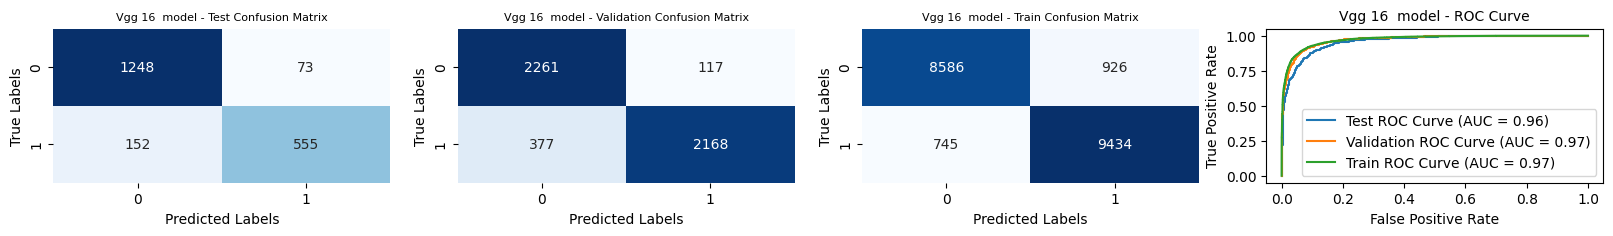

In [ ]:
evaluate_model(model_new, "Vgg 16  model", test_generator, valid_generator,train_generator)